In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import OrderedDict
import warnings

## Load Data

In [36]:
train_ds = np.loadtxt('../assets/training_dataset.txt', dtype=float)
test_ds = np.loadtxt('../assets/test_dataset.txt', dtype=float)
EPOCHS = 800
#suppress warnings
warnings.filterwarnings('ignore')

In [37]:
def data_extract(train_data):
    data_list = list()
    label_list = list()
    for val in train_data:
        data_list.append(val[0:784])
        label_list.append(int(val[784]))
    data_list = np.array(data_list)
    label_list = np.array(label_list)
    return data_list, label_list

np.random.shuffle(train_ds)

x_train, y_train = data_extract(train_ds)
x_test, y_test = data_extract(test_ds)
# x_train = x_train / 255

In [38]:
y_train

array([4, 1, 3, ..., 2, 4, 3])

# Neural Network class

In [39]:
class NeuralNetwork():
    
    def __init__(self, input_neuron: int, output_neurons: int, hidden_neurons: list, hidden_layers: int, learning_rate=0.01, momentum=0.5, epochs=EPOCHS, high=0.75, low=0.25):
        self.input_neuron = input_neuron
        self.output_neurons = output_neurons
        self.hidden_neurons = hidden_neurons
        self.hidden_layers = hidden_layers
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.epochs = epochs
        self.high = high
        self.low = low
        # self.b = np.array([np.random.uniform(-0.5, 0.5, None) for _ in range(self.hidden_neurons[0])])
        self.b1 = np.array([np.random.uniform(-0.5, 0.5, None) for _ in range(self.hidden_neurons[0])]) 
        self.y_hat = OrderedDict()
        self.w1 = np.random.randn(self.hidden_neurons[0], self.input_neuron) * np.sqrt(1 / (self.input_neuron + self.hidden_neurons[0]))
        if hidden_layers < 2:
            self.w2 = np.random.randn(self.output_neurons, self.hidden_neurons[0]) * np.sqrt(1 / (self.output_neurons + self.hidden_neurons[0]))
            self.b2 = np.array([np.random.uniform(-0.5, 0.5, None) for _ in range(self.output_neurons)])
        else:
            # add more bias for other layers
            self.w_dict = dict()
            self.b_dict = dict()
            for i in range(self.hidden_layers):
                temp = 'w' + str(i + 2)
                b_temp = 'b' + str(i + 2)
                if self.hidden_layers - i == 1:
                    self.w_dict[temp] = np.random.rand(self.output_neurons, self.hidden_neurons[i]) * np.sqrt(1 / (self.output_neurons + self.hidden_neurons[i]))
                    self.b_dict[b_temp] = np.array([np.random.uniform(-0.5, 0.5, None) for _ in range(self.output_neurons)])
                    break
                self.w_dict[temp] = np.random.rand(self.hidden_neurons[i + 1], self.hidden_neurons[i]) * np.sqrt(1 / (self.hidden_neurons[i + 1] + self.hidden_neurons[i]))
                self.b_dict[b_temp] = np.array([np.random.uniform(-0.5, 0.5, None) for _ in range(self.hidden_neurons[i])])
    
        
    def get_weight(self):
        if self.hidden_layers >= 2:
            return self.w1, self.w_dict
        return self.w1, self.w2
    
    
    def sigmoid(self, x):
        # if -x > np.log(np.finfo(type(x)).max):
        #     return 0.0    
        return 1.0/(1.0 + np.exp(-x))


    def sigmoid_prime(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    
    def forward_prop(self, input_ds):
        self.z1 = np.dot(input_ds, self.w1.T) + self.b1
        self.y_hat1 = self.sigmoid(self.z1)
        if self.hidden_layers < 2:
            self.z2 = np.dot(self.y_hat1, self.w2.T) + self.b2 # net input 
            self.y_hat2 = self.sigmoid(self.z2) # activation function for the output layer.
        else:
            self.z2 = np.dot(self.y_hat1, self.w_dict['w2'].T) + self.b # net input 
            self.y_hat['y_hat2'] = self.sigmoid(self.z2) # activation function for the output layer.
            for i in range(1, self.hidden_layers):
                temp_y = 'y_hat' + str(i + 1)
                temp_w = 'w' + str(i + 2)
                z = np.dot(self.y_hat[temp_y], self.w_dict[temp_w].T) + self.b
                temp_y = 'y_hat' + str(i + 2)
                self.y_hat[temp_y] = self.sigmoid(z)
                

    def get_output(self):
        if self.hidden_layers < 2:
            return self.y_hat2
        else:
            self.y_hat_val = list(self.y_hat.items())
            self.y_hat_value = np.array(list(self.y_hat_val[len(self.y_hat_val) - 1]))
            return np.asarray(self.y_hat_value[1])            
        
        
    def backward_prop(self, input_ds, y, epochs):
          
        if self.hidden_layers < 2:
            self.threshold(self.y_hat2)
            self.output_errors = y - self.y_hat2
            
            self.d_output = self.output_errors * self.sigmoid_prime(self.y_hat2)
            # print(self.d_output.shape)
            # print(self.w2.shape)
            # print(self.y_hat1.shape)
            # temp = np.dot(self.d_output, self.w2)
            # print(temp.shape)
            self.d_hidden = self.sigmoid_prime(self.y_hat1) * np.dot(self.d_output, self.w2)
            # print(self.y_hat1.shape)
            deltaw2 = self.learning_rate * np.dot(self.y_hat1.T, self.d_output) # Weights change for the second layer (hidden - output)           
            delta21 = self.learning_rate * np.dot(input_ds.T, self.d_hidden) # Weights change for the first layer (input - hidden)

            delta_b1 = 0
            delta_b2 = 0
            
            if epochs > 1: #run after epoch = 1 
                deltaw2 += (self.momentum * self.pre_deltaw2) 
                delta21 += (self.momentum * self.pre_delta21)
                delta_b2 += (self.momentum * self.pre_delta_b2)
                delta_b1 += (self.momentum * self.pre_delta_b1)
                self.w2 = self.w2 + deltaw2.T # for (hidden - output)
                self.w1 = self.w1 + delta21.T # for (input - output)
                self.b1 = self.b1 + delta_b1
                self.b2 = self.b2 + delta_b2
            
            self.pre_deltaw2 = deltaw2 # update of weights change
            self.pre_delta21 = delta21 # update of weights change
            self.pre_delta_b2 = delta_b2
            self.pre_delta_b1 = delta_b1
        
        else:
            
            w_key = ['w' + str(i + 2) for i in range(self.hidden_layers)]
            self.y_hat_val = list(self.y_hat.items())
            self.y_hat_value = np.array(list(self.y_hat_val[len(self.y_hat_val) - 1]))
            self.y_hat_val = np.array(list(self.y_hat_val))            
            self.threshold(self.y_hat_value[1])            
            self.output_errors = y - self.y_hat_value[1]
            index = len(self.y_hat_val) - 1
            
            while (index >= 0):
                self.d_output = self.output_errors * self.sigmoid_prime(self.y_hat_val[index][1])
                self.d_hidden = self.sigmoid_prime(self.y_hat_val[index - 1][1]) * np.dot(self.d_output, self.w_dict[w_key[index]])

                deltaw2 = self.learning_rate * np.dot(np.transpose(self.y_hat_val[index - 1][1]), self.d_output) # Weights change for the second layer (hidden - output)
                delta21 = self.learning_rate * np.dot(np.transpose(input_ds), self.d_hidden) # Weights change for the first layer (input - hidden)

                if(epochs > 1): #run after epoch = 1 
                    deltaw2 += (self.momentum * self.pre_deltaw2)
                    delta21 += (self.momentum * self.pre_delta21)
                    self.w_dict[index] += deltaw2.T # for (hidden - output)
                    self.w_dict[index] += delta21.T # for (input - output)
                
                self.pre_deltaw2 = deltaw2 # update of weights change
                self.pre_delta21 = delta21 # update of weights change
                index -= 1
                self.threshold(self.y_hat_val[index-1][1])               
                self.output_errors = self.y_hat_val[index][1] - self.y_hat_val[index-1][1]
        
        
    def threshold(self, y_hat): #Set threshold for output values. Use during training.
        for q in y_hat:
            for idx, j in enumerate(q):
                if j >= self.high:
                    q[idx] = 1.0
                elif j <= self.low:
                    q[idx] = 0.0
        # for idx in range(len(y_hat)):
        #     if y_hat[idx] >= self.high:
        #         y_hat[idx] = 1.0
        #     elif y_hat[idx] <= self.low:
        #         y_hat[idx] = 0.0

# Train Neural Network

In [56]:
def identify(y):
    results = []
    for data in y:
        max_output = np.amax(data)
        count = 0
        for x in (data): 
            if x == max_output:
                results.append(count)
            count += 1
    return np.asarray(results)

def one_hot_encode(y): # one hot encode the outputs
    one_hot_y = np.zeros((y.size, 10))
    one_hot_y[np.arange(y.size), y] = 1 
    out_hot_labels = one_hot_y.T
    return one_hot_y


def error_fractions(y, yhat): # Get the error fraction
    ERRORS = 0
    yhat_one = one_hot_encode(np.int_(identify(yhat)))
    for i, x in enumerate(y):
        for j in range(len(x)):
            if (x[j] != yhat_one[i][j]):
                ERRORS += 1
                break
    return (ERRORS / len(y)) * 100

In [41]:
nn = NeuralNetwork(784, 10, [180], 1)
nn.forward_prop(x_train)
y_onehot = one_hot_encode(y_train)
y_test_onehot = one_hot_encode(y_test)
w1, w2 = nn.get_weight()
train_error_frac, test_error_frac = list(), list()

In [42]:
w1 # for testing to see in the weight did get train

array([[ 0.035624  , -0.00523425, -0.00672951, ..., -0.03046839,
         0.05192336, -0.00276661],
       [ 0.00136349,  0.01587071,  0.00561849, ...,  0.04048642,
        -0.00624478, -0.00191839],
       [ 0.02917198,  0.07454532,  0.05979734, ..., -0.03739086,
         0.01084661, -0.0286963 ],
       ...,
       [ 0.0590801 ,  0.0558959 , -0.03323169, ...,  0.01099284,
        -0.00959364, -0.02829266],
       [ 0.00807286, -0.01246356, -0.01964645, ..., -0.00931442,
         0.00672902,  0.01538433],
       [-0.00829237,  0.02595002, -0.03625592, ...,  0.01835643,
        -0.01867198, -0.06177528]])

In [43]:
for i in range(EPOCHS + 1):
    nn.forward_prop(x_train)
    if i % 10 == 0:
        print(f'Iteration {i}:')
        temp_train = error_fractions(y_onehot, nn.get_output())
        train_error_frac.append(temp_train)
        print(f'Error fraction: {temp_train}')
    nn.backward_prop(x_train, y_onehot, i)
    if i % 10 == 0:
        nn.forward_prop(x_test)
        temp_test = error_fractions(y_test_onehot, nn.get_output())
        test_error_frac.append(temp_test)

Iteration 0:
Error fraction: 90.05
Iteration 10:
Error fraction: 88.25
Iteration 20:
Error fraction: 83.72500000000001
Iteration 30:
Error fraction: 87.075
Iteration 40:
Error fraction: 43.3
Iteration 50:
Error fraction: 26.474999999999998
Iteration 60:
Error fraction: 23.474999999999998
Iteration 70:
Error fraction: 22.125
Iteration 80:
Error fraction: 18.775
Iteration 90:
Error fraction: 16.3
Iteration 100:
Error fraction: 15.125
Iteration 110:
Error fraction: 14.899999999999999
Iteration 120:
Error fraction: 14.249999999999998
Iteration 130:
Error fraction: 14.149999999999999
Iteration 140:
Error fraction: 15.625
Iteration 150:
Error fraction: 13.0
Iteration 160:
Error fraction: 13.5
Iteration 170:
Error fraction: 11.675
Iteration 180:
Error fraction: 11.325000000000001
Iteration 190:
Error fraction: 10.625
Iteration 200:
Error fraction: 9.9
Iteration 210:
Error fraction: 9.675
Iteration 220:
Error fraction: 11.025
Iteration 230:
Error fraction: 9.375
Iteration 240:
Error fraction: 

# Confusion Matrix

In [ ]:
def index_output(y): 
    max_out = np.amax(y)
    for i, j in enumerate(y):
        if j == max_out:
            return i


def confusion_matrix(y, yhat):
    confuse = np.zeros((10, 10))
    for i, x in enumerate(y):
        y_output = int(index_output(x))
        yhat_output = int(index_output(yhat[i]))
        confuse[y_output][yhat_output] += 1
    return confuse

### Confusion Matrix for training set

In [57]:
nn.forward_prop(x_train)
train_CM = confusion_matrix(y_onehot, one_hot_encode(np.int_(identify(nn.get_output()))))
train_frame = pd.DataFrame(train_CM)
# print(train_frame)
train_frame.style.background_gradient('Greys').set_caption('TRAIN CONFUSION MATRIX').set_properties(**{'text-align': 'center', 
                        'padding': '12px', 
                        'width': '50px'}).set_table_styles([{'selector': 'th.col_heading', 
                         'props': 'text-align: center'},
                        {'selector': 'caption', 
                         'props': [('text-align', 'center'),
                                   ('font-size', '11pt'),
                                   ('font-weight', 'bold')]}])
# train_frame.dfi.export('../assets/train_confusematrix.png')

,0,1,2,3,4,5,6,7,8,9
0,391.000000,0.000000,1.000000,0.000000,0.000000,1.000000,2.000000,1.000000,3.000000,1.000000
1,0.000000,398.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
2,1.000000,3.000000,372.000000,4.000000,1.000000,4.000000,3.000000,4.000000,5.000000,3.000000
3,0.000000,1.000000,8.000000,356.000000,1.000000,17.000000,0.000000,6.000000,7.000000,4.000000
4,0.000000,0.000000,0.000000,0.000000,382.000000,1.000000,0.000000,3.000000,3.000000,11.000000
5,3.000000,1.000000,0.000000,8.000000,1.000000,371.000000,1.000000,4.000000,10.000000,1.000000
6,5.000000,0.000000,3.000000,0.000000,3.000000,4.000000,382.000000,1.000000,2.000000,0.000000
7,3.000000,1.000000,3.000000,2.000000,3.000000,1.000000,0.000000,373.000000,4.000000,10.000000
8,0.000000,0.000000,3.000000,3.000000,2.000000,16.000000,0.000000,2.000000,369.000000,5.000000
9,2.000000,3.000000,0.000000,2.000000,13.000000,2.000000,2.000000,7.000000,9.000000,360.000000


### Confusion matrix for test set

In [45]:
nn.forward_prop(x_test)
test_CM = confusion_matrix(y_test_onehot, one_hot_encode(np.int_(identify(nn.get_output()))))
test_frame = pd.DataFrame(test_CM)
test_frame.style.background_gradient('Greys').set_caption('TEST CONFUSION MATRIX').set_properties(**{'text-align': 'center', 
                        'padding': '12px', 
                        'width': '50px'}).set_table_styles([{'selector': 'th.col_heading', 
                         'props': 'text-align: center'},
                        {'selector': 'caption', 
                         'props': [('text-align', 'center'),
                                   ('font-size', '11pt'),
                                   ('font-weight', 'bold')]}])
# print(test_frame)
# test_frame.dfi.export('../assets/test_confusematrix.png')

,0,1,2,3,4,5,6,7,8,9
0,95.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,1.000000,0.000000
1,0.000000,97.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
2,1.000000,0.000000,83.000000,4.000000,4.000000,1.000000,2.000000,1.000000,4.000000,0.000000
3,0.000000,1.000000,4.000000,82.000000,2.000000,7.000000,0.000000,3.000000,1.000000,0.000000
4,0.000000,0.000000,2.000000,0.000000,83.000000,2.000000,3.000000,1.000000,1.000000,8.000000
5,1.000000,0.000000,1.000000,2.000000,0.000000,88.000000,4.000000,0.000000,4.000000,0.000000
6,1.000000,0.000000,0.000000,0.000000,1.000000,5.000000,91.000000,1.000000,1.000000,0.000000
7,0.000000,1.000000,3.000000,0.000000,1.000000,1.000000,0.000000,88.000000,3.000000,3.000000
8,1.000000,1.000000,2.000000,3.000000,3.000000,6.000000,1.000000,0.000000,81.000000,2.000000
9,1.000000,1.000000,0.000000,0.000000,12.000000,2.000000,0.000000,4.000000,0.000000,80.000000


# Time series plot over time

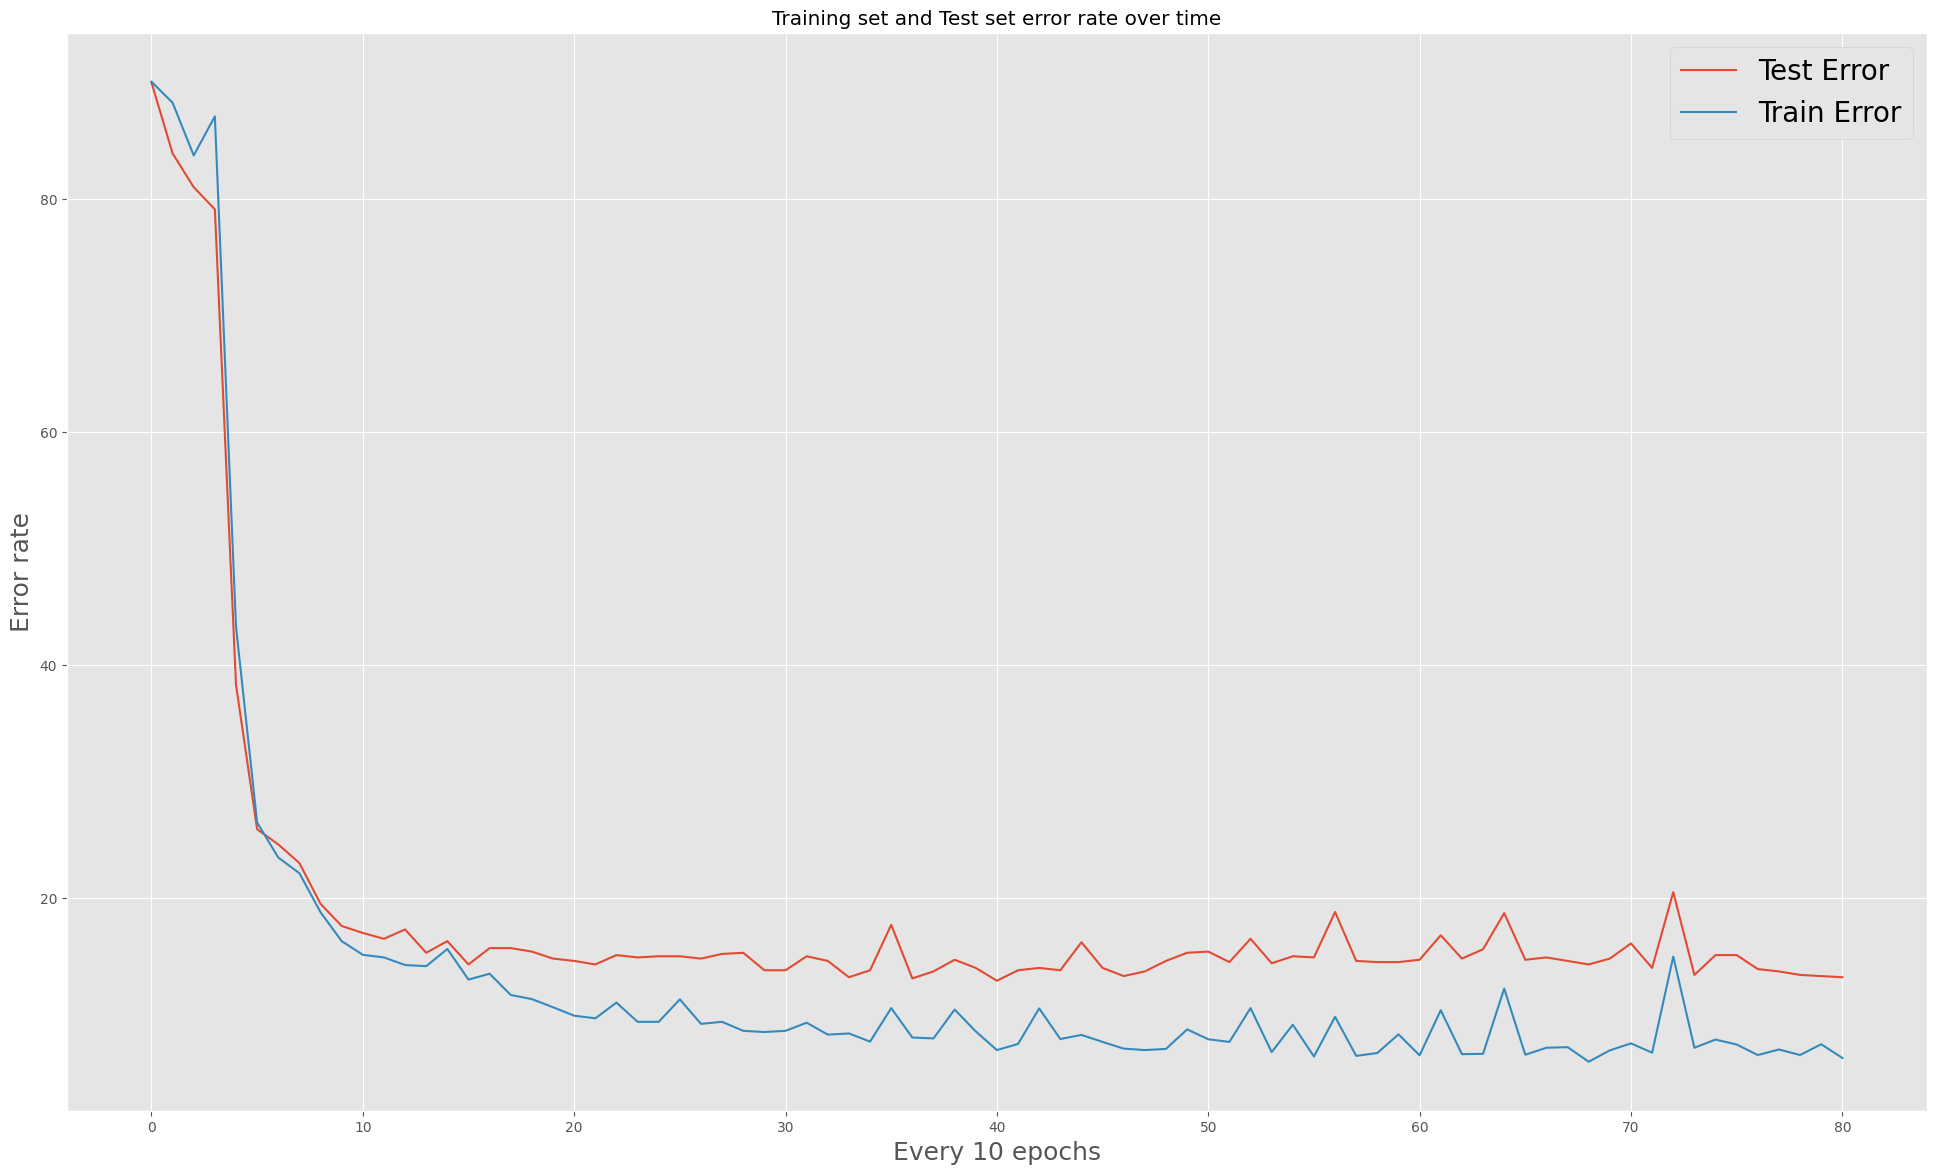

In [51]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(24, 14))
plt.style.use('ggplot')
fraction = [test_error_frac, train_error_frac]
graph_label = ['Test Error', 'Train Error']
for i, x in enumerate(fraction):
    plt.plot(x, label=graph_label[i])
plt.legend(prop={'size': 20})
plt.title('Training set and Test set error rate over time')
plt.xlabel('Every 10 epochs', fontsize=18)
plt.ylabel('Error rate', fontsize=18)
fig.savefig('../assets/error_fraction.png')

In [49]:
nn.forward_prop(x_train)
w1, w2 = nn.get_weight()

np.savetxt('../assets/weight_jk_nn.txt', w1)
np.savetxt('../assets/weight_ij_nn.txt', w2)